# Image Classification with FNNs
---

## Objectives

* Create a small feedforward neural network ([FNN](https://en.wikipedia.org/wiki/Feedforward_neural_network)) leveraging the TensorFlow [Keras API](https://www.tensorflow.org/api_docs/python/tf/keras);
* Train the FNN on the German Traffic Sign Recognition Benchmark ([GTSRB](https://benchmark.ini.rub.de/gtsrb_dataset.html)) dataset;
* Visualise the training and validation metrics. 

## 1. Introduction

Here is a bit of [terminology](https://developers.google.com/machine-learning/glossary/) from the Google Machine Learning Glossary before we get started:
* **Neural network**: a model composed of layers (at least one of which is [hidden](https://developers.google.com/machine-learning/glossary/#hidden_layer));

* **Neuron**: a node in a neural network, typically taking in multiple input values and generating a single output value. The neuron calculates the output value by applying an [activation function](https://developers.google.com/machine-learning/glossary/#activation-function) to a weighted sum of input values;

* **Perceptron**: _nodes_ in a deep neural network. Each perceptron takes in input values, runs an activation function over the weighted sum of values, and computes a single output value. A [backpropagation](https://developers.google.com/machine-learning/glossary/#backpropagation) algorithm is used to introduce feedback into the network;

* **Feedforward Neural Network (FNN)**: a neural network without cyclic or recursive connections (e.g., a _deep neural network_, as opposed to a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network)).

In [ ]:
### Importing the required modules

In [1]:
import os
import glob
import logging
import argparse
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from typing import Generator, Iterator, Tuple

2024-03-19 19:13:06.696488: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 19:13:06.852083: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-19 19:13:07.512812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 19:13:09.743943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.16.1'

In [3]:
tf.test.gpu_device_name()

''

In [4]:
### Setting the environment variables

In [5]:
ENV_COLAB = False                # True if running in Google Colab instance

In [6]:
# Root directory
DIR_BASE = '' if not ENV_COLAB else '/content/'

In [7]:
# Subdirectory to save output files
DIR_OUT = os.path.join(DIR_BASE, 'out/')

# Subdirectory pointing to input data
DIR_SRC = os.path.join(DIR_BASE, 'data/')

In [8]:
### Creating subdirectories (if not exists)
os.makedirs(DIR_OUT, exist_ok=True)

### 1.1. Feedforward Neural Networks (FNNs)

#### Types of FNNs

##### The single-layer perceptron

In its simplest form, a Feedforward Neural Network is a [single-layer perceptron](https://en.wikipedia.org/wiki/Feedforward_neural_network#Single-layer_perceptron). The single-layer perceptron is a network with only one input and one output layer. In [Exercise 1.3.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-3-2-Stochastic-Gradient-Descent/2022-08-29-Stochastic-Gradient-Descent.ipynb), we built a single-layer perceptron that consisted of a single input layer shaped by our input data (the image pixel attributes) and a single output layer (the predicted class distribution of probabilities). The output layer was computed directly from the sum of the product of the input layer units and the perceptron weights (plus a bias term). The output of the single-layer perceptron was then passed into an activation function (the softmax function), and a classification label was selected by choosing the prediction with the highest probability value.

The single-layer perceptron was a powerful yet simple type of Feedforward Neural Network architecture, but as a [linear classifier](https://en.wikipedia.org/wiki/Linear_classifier) it is only capable of learning linearly-separable patterns. As most functions are not linearly-seperable, we will consider a bit more involved approach.

##### The multi-layer perceptron

What's better than _one_ layer of perceptrons? A ton of them!

[Multi-layer perceptrons](https://en.wikipedia.org/wiki/Feedforward_neural_network#Multi-layer_perceptron) (MLPs) are a type of Feedforward Neural Network composed of many single-layer perceptrons. These perceptrons are organised into groups called _layers_. In a MLP, we introduce at least one _hidden_ layer composed of multiple perceptrons. These perceptrons in a hidden layer are not interconnected (i.e., no connections between each other in the same layer) but are said to be "fully connected" to the perceptrons in a preceding layer. In a hidden layer, these perceptrons also have activation functions, similar to the output layer in a single-layer perceptron.

Like single-layer perceptrons, multi-layer perceptrons are trained by iteratively updating the weights and bias values in order to minimise an error (cost) function. Using _stochastic gradient descent_ to adjust these model parameters, we saw in Exercise 1.3.2 that, after a given number of epochs (passes) over our entire dataset, we were able to settle on semi-optimal weight $\mathrm{w}$ and bias $\mathrm{b}$ values.

We can break the training phase into two primary steps with the multi-layer perceptron: a _forward pass_ and a _backwards_ pass. With a _forward_ pass over the data, each layer of perceptrons calculates a sum of products between the perceptron weights and the input values. The resulting values are then passed to an activation function (such as the _Rectified Linear Unit_ — [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))) where a single output value is generated. In a _backwards_ pass over over the network, we update the model parameters (the weights and bias values) using the partial derivative of an error function (like [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression)). With the backpropagation algorithm, values calculated in the forward pass are used to compute the gradients for each of the model parameters. The "backwards" pass here indicates that the gradients are propagated back through the network starting from the output nodes to the nodes in the first hidden layer. The partial computations at each layer are used to update the weight values at each step.

### 1.2. TensorFlow Keras API

[TensorFlow](https://www.tensorflow.org) is a very powerful, highly-optimised platform for machine learning. [Keras](https://github.com/keras-team/keras) is a high-level framework for the TensorFlow platform primarily authored by [François Chollet](https://github.com/fchollet). While Keras used to support a several other backend compute engines, TensorFlow is now the only supported platform in Keras version 2.4+. With the release of TensorFlow 2.0 [came the announcement](https://blog.tensorflow.org/2018/12/standardizing-on-keras-guidance.html) that Keras would be the official high-level API for Google's TensorFlow. Together, the two make a great couple. While Keras focuses on simplistic, highly-readable and abstracted model creation, TensorFlow's full-fledged compute engine gives developers and practitioners the freedom to fine-tune much of their model's low-level implementation.

#### Modelling with the Keras API

##### The `Sequential ` API

In this exercise we will interface with the Keras through TensorFlow's [`Sequential`](https://www.tensorflow.org/guide/keras/sequential_model) API. In [Exercise 1.3.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-3-2-Stochastic-Gradient-Descent/2022-08-29-Stochastic-Gradient-Descent.ipynb) we demonstrated how to implement a model using TensorFlow Keras but didn't touch on many of Keras' core design principles. Given the simplicity of our network architecture, we will be using the Sequential API to model the multi-layer perceptron as a simple stack of layers. The `Sequential` model [approach](https://www.tensorflow.org/guide/keras/sequential_model) is good enough for us in this use case, but is **not appropriate** for any model architecture with:
* multiple inputs or multiple outputs;
* any amount of layers accepting multiple inputs or multiple outputs;
* layer sharing;
* a non-linear topology.

Let's dive a bit more into the Keras abstraction and the classes we will use in our model...

##### The `Layer` base class

Now that we've learned a bit about multi-layer perceptrons, let's see how those layers can actually be implemented in TensorFlow. 

Every `Layer` instance in TensorFlow is born from the the Keras [`layers.Layer`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer) base class. As said by Google themselves, 


_A layer is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves **computation**, defined in the `call()` method, and a **state** (the weight variables) implemented in the `__init__()` method._

A layer in our use case is a set of fully-connected (but not interconnected) units, each with a respective weight value. This _layer_ in a multi-layer perceptron also implements an activation function, and those weight values we discussed are also said to be _trainable_ (that is, that they can be modified during training). We will see that translating this into code using the Keras `Layer` API is a straightforward and easy process. 

With the `Layer` abstraction we also now have access to a whole set of methods and class attributes provided by TensorFlow to help us maintain, monitor, or modify layer state and layer variables during training and more.

##### The `Model` base class

A [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model) groups `Layer`s into a single object while also providing many powerful training and inference features. A `Model` can be initialised in a single line of code and begin providing insane functionality right off-the-shelf. Remember that exhausting [training and validation loop](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Object-Detection-in-Urban-Environments/Exercises/1-3-2-Stochastic-Gradient-Descent/2022-08-29-Stochastic-Gradient-Descent.ipynb) we wrote in the last exercise? With a `Model` instance, we can shorten that entire functionality into just _one line of code_ using the `Model.fit()` method.

One other way to use ` Model` is to [_subclass it_](https://www.tensorflow.org/guide/keras/custom_layers_and_models). In other words, we can create a class that inherits `Model` and from there customise much of the core Keras functionality to suit our own needs. This can be beneficial for those wanting full control over the [lower-level](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#going_lower-level) details of the training cycle, or for those who want to encapsulate complex model architectures, custom callbacks, metric functions, etc. into neat, [serialisable](https://www.tensorflow.org/guide/keras/save_and_serialize/) Model objects.

#### Training and validation with the Keras API

##### The `compile()` method

This `Model` class method is essential for putting together all the pieces in building a model. The [`compile()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile) API allows us to quickly initialise our model instance with all sorts of useful [optimizers](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), [metric](https://www.tensorflow.org/api_docs/python/tf/keras/metrics) and [loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses) functions and be up and running in no time.

##### The `fit()` method

The `Model` [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method is at the heart of our model training process. This class method provides us with all the parameters we need to go from a hollow, untrained model to a fully-trained object detector, image classifier, etc. Our model hyperparameters — the _batch size_, _epochs_, etc. are supplied as input parameters into this method along with our dataset and any considerations we have for it (e.g., whether to `shuffle` the input data, perform a `validation_split` over it, etc.). Lastly, here in the model `fit()` method is where we supply any `callbacks` we want to include alongside the training process.

Once your input parameters are good to go, training a model is really just as simple as executing this line of code. The `fit()` method will even handle printing out updates to the console for you — a nice progress bar and some helpful metrics at every iteration of training. No wonder Keras has been [such a hit](https://blog.tensorflow.org/2018/12/standardizing-on-keras-guidance.html) at Google!

##### The `callbacks` functionality

In addition to the benefits aforementioned when using the Keras `fit()` API for training, we also get the ability to specify [`callbacks`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback). Callbacks are functions that get passed into the `fit()`, `evaluate()` and `predict()` methods of a model in order to customise their functionality or run your own code on regular intervals (e.g., at the end of each epoch). While some callback functionality is baked in by default (e.g., [`callbacks.History`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)), several other popular callbacks exist. One of those is the [`callbacks.LearningRateScheduler`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) which serves as a base class for all custom learning rate schedulers (e.g., [`optimizers.schedules.ExponentialDecay`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler)). Through [_subclassing_](https://www.tensorflow.org/guide/keras/custom_layers_and_models) we can override some of the callback methods and provide our own to do things like update our model's learning rate using a custom function on every epoch, for example. 

One last callback worth mentioning here for our own use is [`callbacks.TensorBoard`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard). This callback allows our model to log certain events throughout the training process, such as metrics summaries or weight updates, in order to visualise them in detail during the training cycle. The [TensorBoard dashboard](https://www.tensorflow.org/tensorboard/get_started) provides a nice graphical interface to monitor real-time, interactive plots, graphs and charts of important training metrics and other stats. We can even use these real-time plots in TensorBoard to [visualise layer weights](http://cs231n.github.io/understanding-cnn/) or [monitor confusion matrices](https://www.tensorflow.org/tensorboard/image_summaries#building_an_image_classifier) on each epoch, all with the help of callbacks.

## 2. Programming Task

From the Introduction you by now should have a decent overview of TensorFlow and some of the essential functionality Keras brings to it. In this section, we will implement a Feedforward Neural Network (FNN) for image classification on the German Traffic Sign Recognition (GTSRB), starting with a simple `Sequential` model architecture and adding complexity from there.

### 2.1. Feedforward Neural Networks (FNNs)

The neural network you create should have less than 4 layers, including the output layer. This last layer should not be activated. Take the time to experiment with different architecture (number of layers, number of neurons) and see how it impacts the results.

In [9]:
### From Udacity's `training.py`

In [10]:
def create_network(
        input_shape: Tuple[int, int, int], output_shape: int, 
        model_name: str='FeedforwardNeuralNetwork') -> tf.keras.Model:
    """Creates a simple Feedforward Neural Network.
    
    :param input_shape: a tuple describing the image shape
        without considering the batch size dimension.
    :param output_shape: an integer value of the number of distinct classes.
    :param model_name: a string describing the model name.
    :returns: a tf.keras.Model instance, a FNN built using the TensorFlow
        Keras Sequential API model.
    """
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(output_shape)], 
        name=model_name
    )
    return model

In [11]:
### Defining our model parameters

In [12]:
model_params = {}

In [13]:
IMG_SIZE = 32                                     # Each RGB image has 32x32 px resolution
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)               # Each RGB image has 3 channels (R,G,B)

In [14]:
N_CLASSES = 43                                    # The GTSRB has 43 distinct classes

In [15]:
model_params.update({'input_shape': IMG_SHAPE})

In [16]:
model_params.update({'n_classes': N_CLASSES})

In [17]:
model_params.update({'model_name': 'FeedforwardNeuralNetwork'})

In [18]:
### Initialising the FNN
model = create_network(input_shape=model_params['input_shape'],
                       output_shape=model_params['n_classes'],
                       model_name=model_params['model_name']
)

/home/op/sem2/AIAV/aiav_env/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.input_shape

(None, 32, 32, 3)

In [20]:
model.output_shape

(None, 43)

### 2.2. Modelling with TensorFlow Keras API

In [21]:
### Defining our optimizer hyperparameters

In [22]:
model_params.update({'learning_rate': 1e-1})

In [23]:
decay = False                                     # Whether or not to use a learning rate schedule

In [24]:
initial_lr = model_params['learning_rate']
decay_rate = 0.96                                 # Amount to decay learning rate by (decrease by 96%)
decay_steps = 128 * 10                            # When to modify learning rate (every interval of `decay_steps`)

In [25]:
### Initialising a learning rate schedule
# See: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay

In [26]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=initial_lr,
                        decay_steps=decay_steps,
                        decay_rate=decay_rate,
                        staircase=True
)

In [27]:
model_params.update({'lr_schedule': lr_schedule})

In [28]:
### Selecting the optimiser and activation functions 
# See: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

In [29]:
optimizer = tf.keras.optimizers.Adam(
                learning_rate=model_params['learning_rate'] if not decay else (
                              model_params['lr_schedule']),
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=False,
                name='Adam'
)

In [30]:
### Choosing the loss and performance metrics
# See: https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
# See: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy

In [31]:
# Here we specify `from_logits=True` since we are not using the 
# 'softmax' activation function in the last layer of our model
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [32]:
accuracy_fn = tf.keras.metrics.Accuracy()

In [33]:
### Compiling the model using the `compile()` API
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile

In [34]:
# Here we use the stock 'adam' optimizer for best performance

In [35]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy']
)

### 2.3. Training and validation

In [36]:
### Setting the training hyperparameters

In [37]:
model_params.update({'epochs': 20})
# Using batch size of 128 (mini-batching as in D. Kingma, 2015)
model_params.update({'batch_size': 128})
model_params.update({'shuffle': True})

In [38]:
### Usage of the `callbacks()` method
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [39]:
### From Udacity's `utils.py`

In [40]:
def get_module_logger(mod_name: str) -> logging.Logger:
    """Initialises a console logger instance.
    
    :param mod_name: the model name to assign to the logger.
    :returns: a logger instance.
    """
    
    ### Setting up the console logger and formatter
    logger = logging.getLogger(mod_name)
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s %(levelname)-8s %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.DEBUG)
    ### Prevent messages going to root handler
    logger.propagate = False
    return logger

In [41]:
logger = get_module_logger(model.name)

### 2.4. Evaluation on the GTSRB dataset

#### Considerations for our input data

In [42]:
### Defining our input image specs

In [43]:
image_size = (32, 32)          # Each RGB image has 32x32 px resolution
n_features = (32 * 32) * 3     # Each pixel value is considered an attribute (feature)

In [44]:
model_params.update({'image_size': image_size})
model_params.update({'n_features': n_features})

#### Putting it all together

##### Fetching the GTSRB data

You will need to specify the `--imdir`, e.g. `--imdir GTSRB/Final_Training/Images/`, using the provided GTSRB dataset.

In [45]:
# imdir = os.path.join(DIR_SRC, 'GTSRB/Final_Training/Images')
print(DIR_SRC)
imdir = os.path.join(DIR_SRC, 'GTSRB/Final_Training/Images')
print(imdir)

data/
data/GTSRB/Final_Training/Images


In [46]:
model_params.update({'imdir': imdir})

The following `get_datasets()` method returns a tuple of [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) instances containing the training and validation datasets, respectively.

In [47]:
### From Udacity's `utils.py`

In [48]:
def get_datasets(imdir: str) -> tuple:
    """Return the training and validation datasets.
    
    :param imdir: absolute path to the directory where the data is stored in.
    :returns: (train_dataset, validation_dataset), tuple of tf.data.Dataset instances.
    """
    
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        imdir,
                        labels='inferred',
                        label_mode='int',
                        color_mode='rgb',
                        batch_size=model_params.get('batch_size', 1),
                        image_size=model_params.get('image_size', (32, 32)),
                        shuffle=True,
                        seed=123,
                        validation_split=0.1,
                        subset='training',
    )
    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                        imdir,
                        labels='inferred',
                        label_mode='int',
                        color_mode='rgb',
                        batch_size=model_params.get('batch_size', 1),
                        image_size=model_params.get('image_size', (32, 32)),
                        shuffle=True,
                        seed=123,
                        validation_split=0.1,
                        subset='validation',
    )
    return train_dataset, validation_dataset

In [49]:
### Fetching the training and validation datasets
train_dataset, validation_dataset = get_datasets(model_params['imdir'])

Found 39209 files belonging to 43 classes.
Using 35289 files for training.
Found 39209 files belonging to 43 classes.
Using 3920 files for validation.


##### Processing the image data

In [50]:
### Number of features (pixel values) in a single image
train_iter = iter(train_dataset)
len(train_iter.get_next()[0][0].numpy().flatten())

3072

In [51]:
def process(dataset: tf.data.Dataset) -> Generator[tuple, None, None]:
    """Processes the input dataset and returns a generator object.

    :param dataset: the tf.data.Dataset instance of batched image, label data.
    :returns: the generator instance modifying the image attribute values.
    """

    def process_generator() -> Iterator[Tuple[tf.Tensor, tf.Tensor]]:
        """Scales the input image data.
        
        Unbatches the tf.data.Dataset and scales all image attributes,
        i.e., pixel values, in the range [0, 1].

        :returns: an iterator yielding the modfied image data and
            corresponding label.
        """

        for batch in dataset:
            for image, label in zip(*batch):
                image = tf.cast(image/255. ,tf.float32)
                yield image, label
    return process_generator

In [52]:
### Unbatching the datasets and scaling the images

In [53]:
train_dataset_scaled = tf.data.Dataset.from_generator(
                                generator=process(train_dataset), 
                                output_types=(tf.float32, tf.int32), 
                                output_shapes=(model_params['input_shape'], ())
).batch(model_params['batch_size'])

In [54]:
validation_dataset_scaled = tf.data.Dataset.from_generator(
                                generator=process(validation_dataset), 
                                output_types=(tf.float32, tf.int32), 
                                output_shapes=(model_params['input_shape'], ())
).batch(model_params['batch_size'])

In [55]:
type(validation_dataset_scaled)

tensorflow.python.data.ops.batch_op._BatchDataset

##### Performing the training and validation loops

In [56]:
### From Udacity's `training.py`

In [57]:
logger.info(f"\nTraining for {model_params['epochs']} epochs " + 
            f"using '{model_params['imdir']}' data")

2024-03-19 19:13:55,551 INFO     
Training for 20 epochs using 'data/GTSRB/Final_Training/Images' data


In [58]:
### Usage of the `fit()` API
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit

In [59]:
history = model.fit(
                x=train_dataset_scaled,
                epochs=model_params.get('epochs', 10),
                batch_size=model_params.get('batch_size', 128),
                validation_data=validation_dataset_scaled,
                shuffle=True
)

Epoch 1/20
    276/Unknown 73s 257ms/step - accuracy: 0.3260 - loss: 2.7254

2024-03-19 19:15:08.470617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:15:08.501785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 286ms/step - accuracy: 0.3266 - loss: 2.7231 - val_accuracy: 0.6875 - val_loss: 1.1985
Epoch 2/20


2024-03-19 19:15:16.318862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:15:16.325930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.7245 - loss: 1.0780

2024-03-19 19:16:27.503590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:16:27.521696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 286ms/step - accuracy: 0.7246 - loss: 1.0775 - val_accuracy: 0.8232 - val_loss: 0.6957
Epoch 3/20


2024-03-19 19:16:35.443652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:16:35.455399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.8357 - loss: 0.6684

2024-03-19 19:17:46.194036: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:17:46.211473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.8358 - loss: 0.6682 - val_accuracy: 0.8577 - val_loss: 0.5689
Epoch 4/20


2024-03-19 19:17:54.233568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:17:54.247484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8674 - loss: 0.5189

2024-03-19 19:19:05.185062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:19:05.202571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.8674 - loss: 0.5188 - val_accuracy: 0.8546 - val_loss: 0.4996
Epoch 5/20


2024-03-19 19:19:13.234543: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:19:13.240606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.8817 - loss: 0.4457

2024-03-19 19:20:23.750838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:20:23.768512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 282ms/step - accuracy: 0.8817 - loss: 0.4457 - val_accuracy: 0.8778 - val_loss: 0.4649
Epoch 6/20


2024-03-19 19:20:31.409726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:20:31.416726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8937 - loss: 0.4164

2024-03-19 19:21:42.353034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:21:42.373852: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 284ms/step - accuracy: 0.8937 - loss: 0.4163 - val_accuracy: 0.8931 - val_loss: 0.4116
Epoch 7/20


2024-03-19 19:21:49.987639: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:21:49.997649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9078 - loss: 0.3516

2024-03-19 19:23:00.241692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:23:00.260909: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 281ms/step - accuracy: 0.9078 - loss: 0.3515 - val_accuracy: 0.8997 - val_loss: 0.3652
Epoch 8/20


2024-03-19 19:23:07.769976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:23:07.776784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9186 - loss: 0.3159

2024-03-19 19:24:19.374878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:24:19.394376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 287ms/step - accuracy: 0.9186 - loss: 0.3159 - val_accuracy: 0.9235 - val_loss: 0.3106
Epoch 9/20


2024-03-19 19:24:27.031286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:24:27.039156: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9268 - loss: 0.2815

2024-03-19 19:25:37.370128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:25:37.390037: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 281ms/step - accuracy: 0.9268 - loss: 0.2816 - val_accuracy: 0.8977 - val_loss: 0.3606
Epoch 10/20


2024-03-19 19:25:44.943375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:25:44.949580: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9284 - loss: 0.2774

2024-03-19 19:26:55.757925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:26:55.778115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 284ms/step - accuracy: 0.9284 - loss: 0.2773 - val_accuracy: 0.9268 - val_loss: 0.2665
Epoch 11/20


2024-03-19 19:27:03.388182: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:27:03.394307: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9376 - loss: 0.2431

2024-03-19 19:28:15.176835: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:28:15.197302: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 80s 288ms/step - accuracy: 0.9376 - loss: 0.2431 - val_accuracy: 0.9291 - val_loss: 0.2480
Epoch 12/20


2024-03-19 19:28:22.932240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:28:22.939241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9437 - loss: 0.2164

2024-03-19 19:29:33.531410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:29:33.549361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 78s 283ms/step - accuracy: 0.9437 - loss: 0.2164 - val_accuracy: 0.9367 - val_loss: 0.2465
Epoch 13/20


2024-03-19 19:29:41.114140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:29:41.120507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9431 - loss: 0.2181

2024-03-19 19:30:52.474157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:30:52.493471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.9431 - loss: 0.2180 - val_accuracy: 0.9171 - val_loss: 0.2963
Epoch 14/20


2024-03-19 19:30:59.980974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:30:59.987970: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9411 - loss: 0.2156

2024-03-19 19:32:11.108762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:32:11.126459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.9411 - loss: 0.2156 - val_accuracy: 0.9357 - val_loss: 0.2412
Epoch 15/20


2024-03-19 19:32:18.743238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:32:18.750381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9528 - loss: 0.1773

2024-03-19 19:33:30.098511: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:33:30.119010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 286ms/step - accuracy: 0.9528 - loss: 0.1773 - val_accuracy: 0.9222 - val_loss: 0.2713
Epoch 16/20


2024-03-19 19:33:37.784713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:33:37.791041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9477 - loss: 0.1970

2024-03-19 19:34:48.900739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:34:48.918857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 286ms/step - accuracy: 0.9477 - loss: 0.1970 - val_accuracy: 0.9423 - val_loss: 0.2283
Epoch 17/20


2024-03-19 19:34:56.787946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:34:56.794398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9595 - loss: 0.1504

2024-03-19 19:36:08.158856: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:36:08.177661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.9595 - loss: 0.1504 - val_accuracy: 0.9176 - val_loss: 0.3260
Epoch 18/20


2024-03-19 19:36:15.678088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:36:15.684754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.9531 - loss: 0.1730

2024-03-19 19:37:27.195636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:37:27.216561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 285ms/step - accuracy: 0.9531 - loss: 0.1730 - val_accuracy: 0.9508 - val_loss: 0.1951
Epoch 19/20


2024-03-19 19:37:34.644553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:37:34.651415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9560 - loss: 0.1579

2024-03-19 19:38:45.475864: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:38:45.494445: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 79s 284ms/step - accuracy: 0.9560 - loss: 0.1579 - val_accuracy: 0.9449 - val_loss: 0.2309
Epoch 20/20


2024-03-19 19:38:53.214291: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:38:53.220658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.9629 - loss: 0.1315

2024-03-19 19:40:06.807920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:40:06.828966: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


276/276 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.9629 - loss: 0.1316 - val_accuracy: 0.9582 - val_loss: 0.1679


2024-03-19 19:40:14.215319: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-03-19 19:40:14.221999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


##### Visualising the results

Lastly, at the end of training, you will need to be in the `Desktop` view to see the metrics visualization.

In [60]:
### From Udacity's `utils.py`

In [67]:
def display_metrics(history: tf.keras.callbacks.History):
    """Plots the per-epoch loss and accuracy metrics.
    
    :param history: the Keras `callbacks.History` object.
    """
    
    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(history.history['loss'], linewidth=3)
    ax[0].plot(history.history['val_loss'], linewidth=3)
    ax[0].set_title('Loss', fontsize=16)
    ax[0].set_ylabel('Loss', fontsize=16)
    ax[0].set_xlabel('Epoch', fontsize=16)
    ax[0].legend(['train loss', 'val loss'], loc='upper right')
    ax[1].plot(history.history['accuracy'], linewidth=3)
    ax[1].plot(history.history['val_accuracy'], linewidth=3)
    ax[1].set_title('Accuracy', fontsize=16)
    ax[1].set_ylabel('Accuracy', fontsize=16)
    ax[1].set_xlabel('Epoch', fontsize=16)
    ax[1].legend(['train acc', 'val acc'], loc='upper left')
    plt.show()

In [62]:
# type(history)

In [63]:
### From Udacity's `training.py`

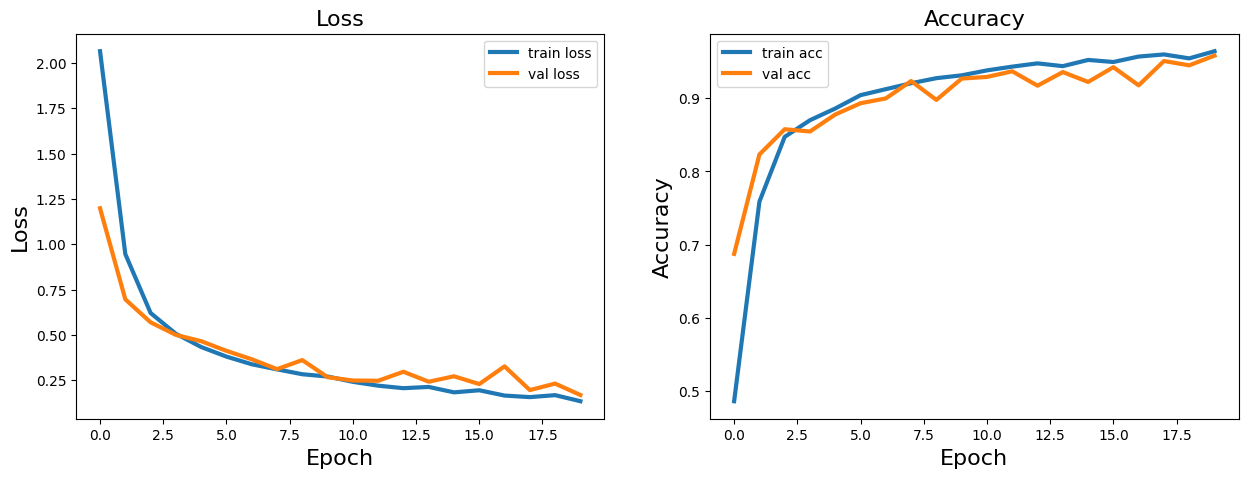

In [68]:
display_metrics(history)

##### Save Model

In [65]:
# Save the entire model as a `.keras` zip archive.
model_path = os.path.join(DIR_OUT, 'gtsrb_model.keras')
model.save(model_path)

## 3. Closing Remarks

##### Alternatives
* Try out other Keras [`optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), 
e.g., [RMSprop](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop);
* Add additional `Layer`s (e.g., [`Dropout`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)) or modify exisiting `Dense` layers (e.g., the number of unts).

##### Extensions of task
* Use [`TensorBoard`](https://www.tensorflow.org/tensorboard/get_started) to visualise weight updates during training;
* Run the trained model on test set and plot a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to visualise class prediction scores.

## 4. Future Work

- ✅ Create more complex model architectures for image classification (e.g., a [Convolutional Neural Network](https://www.tensorflow.org/tutorials/images/cnn) — see [Exercise 1.4.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-4-2-Building-Custom-CNNs/2022-09-12-Building-Custom-Convolutional-Neural-Networks.ipynb));
- ✅ Track evaluation metrics (e.g., F1-score, precision/recall — see [Exercise 1.5.2](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-5-2-Mean-Average-Precision/2022-09-25-Mean-Average-Precision.ipynb));
- ✅ Evaluate trained model on test dataset (e.g., Waymo Open Dataset — see [Project 1.1: Report](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/1-1-Object-Detection-in-Urban-Environments/2022-10-16-Report.md));
- ✅ Use TensorBoard to visualise updates during training (e.g., losses and evaluation metrics — see [Project 1.1: Report](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/1-1-Object-Detection-in-Urban-Environments/2022-10-16-Report.md)).

## Credits

The base notebook is used from [GitHub - Jonathan Moran](https://github.com/jonathanloganmoran/ND0013-Self-Driving-Car-Engineer/blob/main/1-Computer-Vision/Exercises/1-3-3-Image-Classification-FNNs/2022-09-05-Image-Classification-Feed-Forward-Neural-Networks.ipynb)

References
* [1] Kingma, D. and Ba, J. Adam: A Method for Stochastic Optimization. arXiv (2014). [doi:10.48550/arXiv.1412.6980](https://arxiv.org/abs/1412.6980v9).


Helpful resources:
* [Feedforward Neural Networks | Brilliant.org](https://brilliant.org/wiki/feedforward-neural-networks/)
* [Standardizing on Keras: Guidance on High-level APIs in TensorFlow 2.0 | Google TensorFlow Blog](https://blog.tensorflow.org/2018/12/standardizing-on-keras-guidance.html)